<a href="https://colab.research.google.com/github/pablovillauy/tensorflow/blob/master/TensorFlow_2_0_Algorithms_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TensoFlow Algorithms - Linear Regression**

**First contact with TensorFlow Estimator.**

The high-level TensorFlow API that greatly simplifies ML programming.

**Links**

https://towardsdatascience.com/first-contact-with-tensorflow-estimator-69a5e072998d

https://www.tensorflow.org/tutorials/estimator/linear

https://www.youtube.com/watch?v=tPYj3fFJGjk&t=15s

**Linear Regression**

In statistics, linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression.

We need to find a and b to solve the linear formula

y = ax + b

x = independent variable

y = dependent variable


**Sample. Predict passenger survival in the sinking of the Titanic.**

We will consider people charasteristics such as gender, age, class.

In [0]:
pip install -q sklearn

In [0]:
# Import libraries
import os
import sys

import numpy as np # arrays, multidimensional calculations, represent and manipulate data, vector and matrix operations
import pandas as pd # data and analytics tools, manipulate data, load data, visualize data
import matplotlib.pyplot as plt # graphs and charts
from IPython.display import clear_output
from six.moves import urllib

In [0]:
# Load Titanic dataset
# %tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived') # create an array with survived column and removes it from dftrain
y_eval = dfeval.pop('survived')


In [28]:
print(dftrain.loc[0]) # print first row of dftrain

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object


In [29]:
print(y_train.loc[0])

0


In [30]:
print(type(y_train))
y_train

<class 'pandas.core.series.Series'>


0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [31]:
# Explore the data
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [32]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [33]:
dftrain.shape[0], dfeval.shape[0]
# There are 627 and 264 examples in the training and evaluation sets, respectively.

(627, 264)

In [34]:
dftrain.columns

# 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

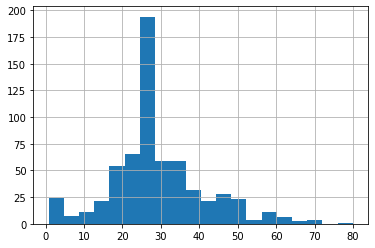

In [35]:
dftrain.age.hist(bins=20)
# The majority of passengers are in their 20's and 30's.

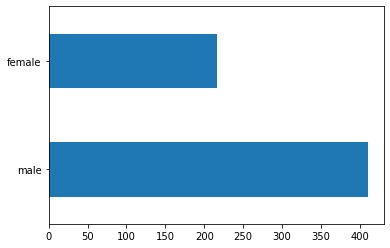

In [36]:
dftrain.sex.value_counts().plot(kind='barh')
# There are approximately twice as many male passengers as female passengers aboard.

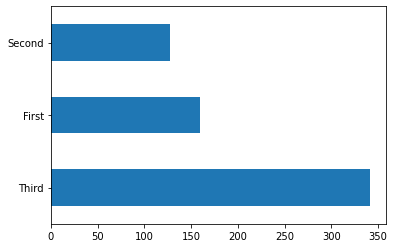

In [37]:
# The majority of passengers were in the "third" class.
dftrain['class'].value_counts().plot(kind='barh')


Text(0.5, 0, '% survive')

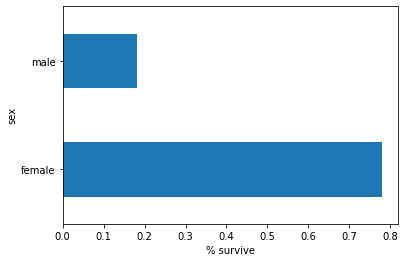

In [38]:
# Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

### Training vs Testing Data
You may have noticed that we loaded **two different datasets** above. This is because when we train models, we need two sets of data: **training and testing**. 

The **training** data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The **testing** data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it.

The point of our model is to be able to make predictions on NEW data, data that we have never seen before. If we simply test the model on the data that it has already seen we cannot measure its accuracy accuratly. We can't be sure that the model hasn't simply memorized our training data. This is why we need our testing and training data to be seperate.



**Feature Columns**
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our categorical data is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2).

In [0]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # gets a list of all unique values from given features column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [40]:
dftrain['sex'].unique()
# array(['male', 'female'], dtype=object)

array(['male', 'female'], dtype=object)

Essentially what we are doing here is creating a list of features that are used in our dataset.

The cryptic lines of code inside the append() create an object that our model can use to map string values like "male" and "female" to integers. This allows us to avoid manually having to encode our dataframes.

And here is some relevant documentation

https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable

Use this when your inputs are in string or integer format, and you have an in-memory vocabulary mapping each value to an integer ID. By default, out-of-vocabulary values are ignored. Use either (but not both) of num_oov_buckets and default_value to specify how to include out-of-vocabulary values.

For input dictionary features, features[key] is either Tensor or SparseTensor. If Tensor, missing values can be represented by -1 for int and '' for string, which will be dropped by this feature column.

In [41]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

**The Training Process**

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of epochs.

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times, we need to create something called an input function. The input function simply defines how our dataset will be converted into batches at each epoch.

The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object. This means we must create a input function that can convert our current pandas dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear).

In [0]:
# The input_function specifies how data is converted to a tf.data.Dataset that feeds the input pipeline in a streaming fashion.
# tf.data.Dataset can take in multiple sources such as a dataframe, a csv-formatted file, and more.

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create tf.data.Dataset object with data and its label
    if shuffle:
      # randomize order of data
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
    # return a batch of the dataset
    return ds
  return input_function # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train) # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [43]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'First' b'Second' b'Second' b'Second' b'Second'
 b'Third' b'First' b'Third']

A batch of Labels: [1 0 1 1 0 0 1 0 0 0]


In [44]:
# You can also inspect the result of a specific feature column using the tf.keras.layers.DenseFeatures layer:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[49.],
       [17.],
       [38.],
       [28.],
       [35.],
       [31.],
       [27.],
       [40.],
       [51.],
       [28.]], dtype=float32)

In [45]:
# DenseFeatures only accepts dense tensors, to inspect a categorical column you need to transform that to a indicator column first:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Training**

In [46]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.74242425, 'accuracy_baseline': 0.625, 'auc': 0.83161914, 'auc_precision_recall': 0.7931916, 'average_loss': 0.48983273, 'label/mean': 0.375, 'loss': 0.48357624, 'precision': 0.6396396, 'prediction/mean': 0.43788064, 'recall': 0.7171717, 'global_step': 200}


And we now we have a model with a 74% accuracy (this will change each time)! Not crazy impressive but decent for our first try.

Now let's see how we can actually use this model to make predicitons.

We can use the .predict() method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

As you can see the survival rate is not very high :/

In [0]:
# To learn the differences between different feature combinations, you can add crossed feature columns to the model (you can also bucketize age column before the cross column):

age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)


In [48]:
# After adding the combination feature to the model, let's train the model again:

derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8466789, 'auc_precision_recall': 0.78502965, 'average_loss': 0.46647266, 'label/mean': 0.375, 'loss': 0.45771667, 'precision': 0.6666667, 'prediction/mean': 0.38686806, 'recall': 0.68686867, 'global_step': 200}


It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. You can try using more features and transformations to see if you can do better!

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier, the eval_input_fn was defined using the entire evaluation set.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb00w4q4q/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


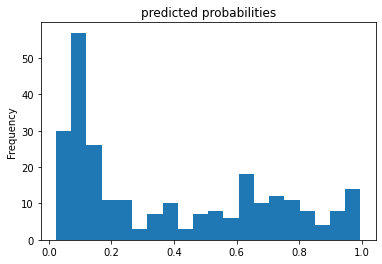

In [49]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

Finally, look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.



(0.0, 1.05)

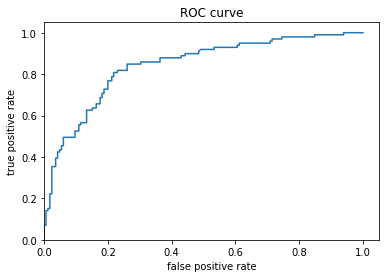

In [0]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)